# CI data analysis: spectrum and seasonal decomposition

In [1]:
# import libraries
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from utils import *
from scipy.signal import get_window

# data preparation:
_dfs = load_data()

# countries to study:
countries = ['Ireland', 'Germany', 'Great Britain', 'France', 'Sweden', 'Finland', 'Belgium']
list_colors = ['blue', 'green', 'orange', 'red', 'purple', 'pink', 'yellow']

# countries = ['Ireland', 'Germany', 'Great Britain']
# list_colors = ['red', 'green', 'blue']

## Spectral analysis

Matlab: Spectral analysis is the process of estimating the power spectrum (PS) of a signal from its time-domain representation. Spectral density characterizes the frequency content of a signal or a stochastic process. Intuitively, the spectrum decomposes the signal or the stochastic process into the different frequencies, and identifies periodicities. The most commonly used instrument for performing spectral analysis is the spectrum analyzer.


GPT: If the mean of your time series is not zero, the Fourier Transform will have a large value at frequency zero. This is because a non-zero mean can be thought of as a constant signal, and a constant signal is just a sinusoid with a frequency of zero.

Warning: when we remove the mean CI, the DC component (mean of the time series) is now zero, and the remaining components represent deviations from the mean.

**Tests:**

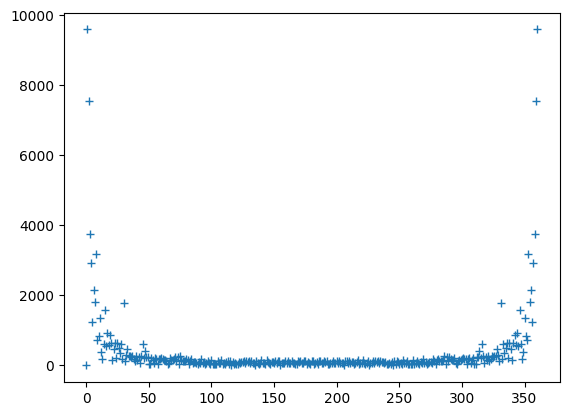

In [2]:
country='Belgium'
start_date = datetime(2022, 1, 1, 0, 0) # year, month, day, hour, min
end_date = start_date + timedelta(hours=24*15)
CI_values=get_CI_values(_dfs, country, start_date, end_date)
CI_values = CI_values - CI_values.mean()   
fft = np.fft.fft(CI_values)

# # extract real part 
# x = [ele.real for ele in fft] 
# # extract imaginary part 
# y = [ele.imag for ele in fft] 
# # plot the complex numbers 
# plt.scatter(x, y, '+') 


plt.plot(np.abs(fft), '+')

### Spectrum of the different countries

<Figure size 600x1800 with 0 Axes>

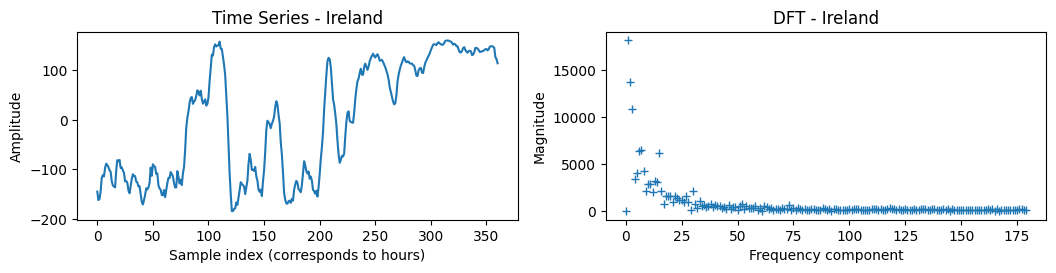

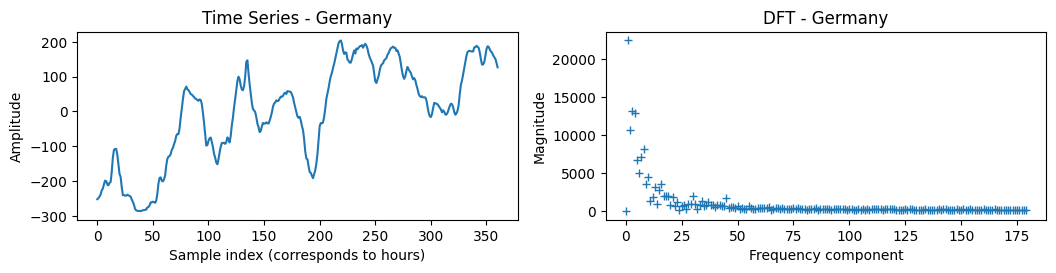

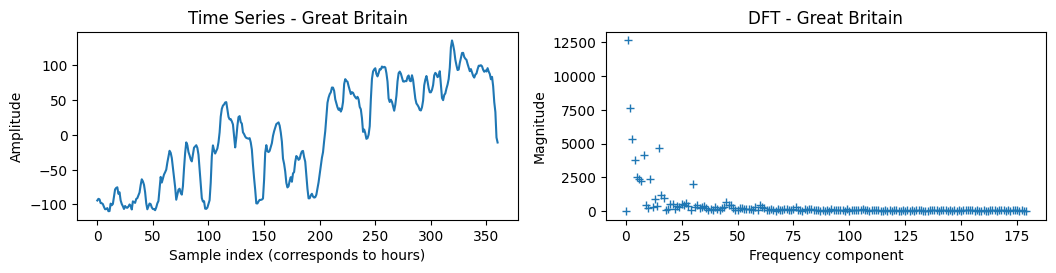

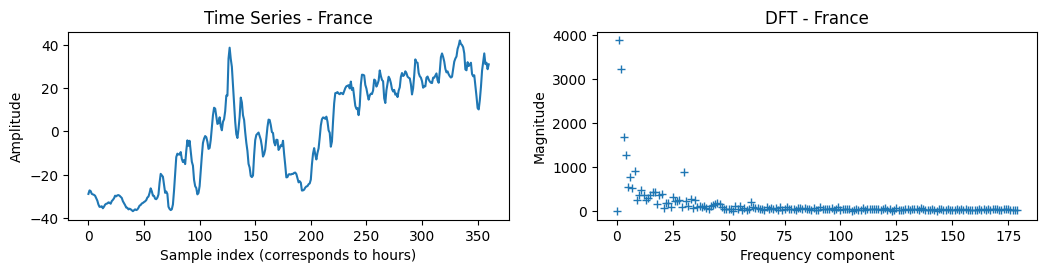

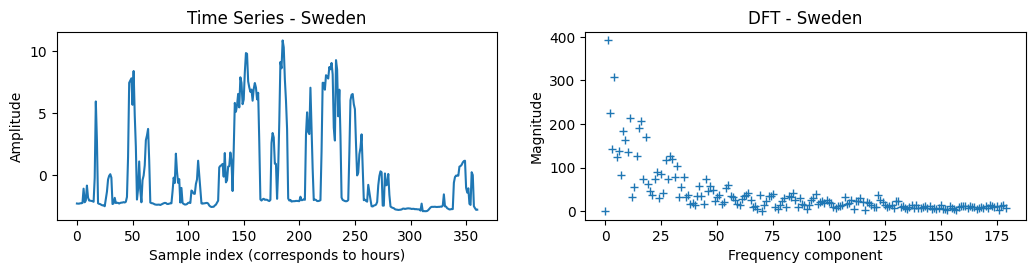

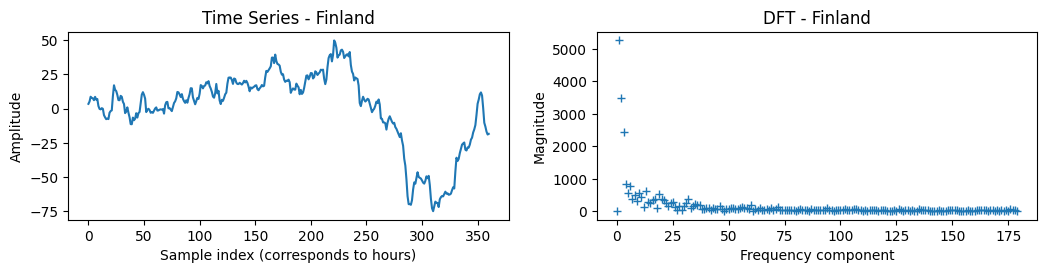

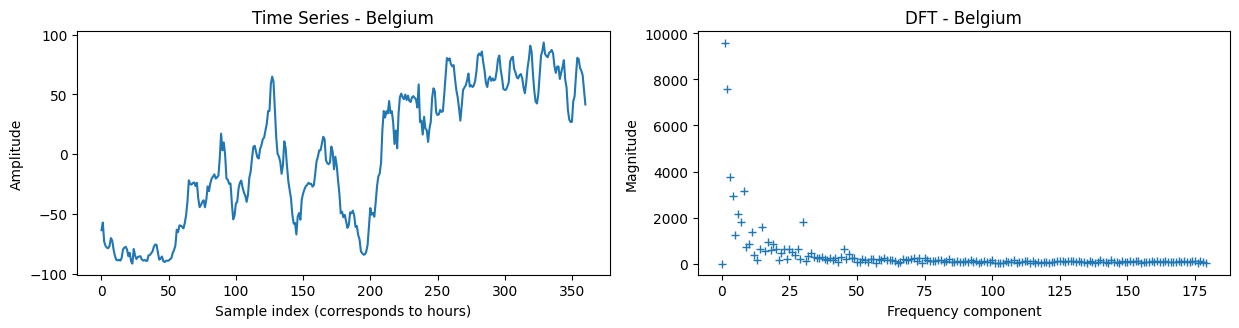

In [3]:
start_date = datetime(2022, 1, 1, 0, 0) # year, month, day, hour, min
end_date = start_date + timedelta(hours=24*15)

plt.figure(figsize=(6, 18))

# countries = 

pos=1
for country in countries:
    # CI_values = np.array(get_CI_values(_dfs, country, start_date, end_date))
    CI_values = get_CI_values(_dfs, country, start_date, end_date)
    CI_values = CI_values - CI_values.mean()                                        # WE REMOVE THE MEAN
    # window = get_window(windows[0], len(CI_values))
    # CI_values_2 = CI_values * window   # Apply the window to the time series
    plot_fft(CI_values, pos, len(countries), country)
    pos+=2

plt.tight_layout()
plt.show()

### Test of various windows for the country Belgium

If the frequency component is k, then the frequency in Hertz is sampling_rate*k/nb_samples. Here, the sampling rate in Hertz is 1/3600 since there is one sample per hour.

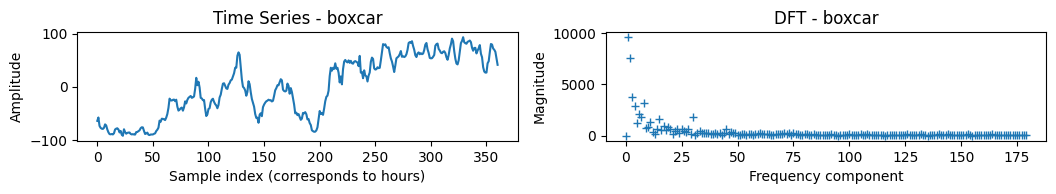

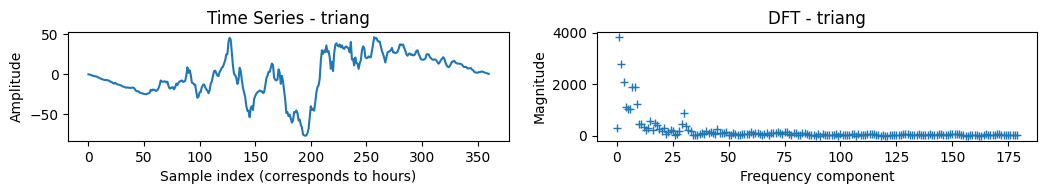

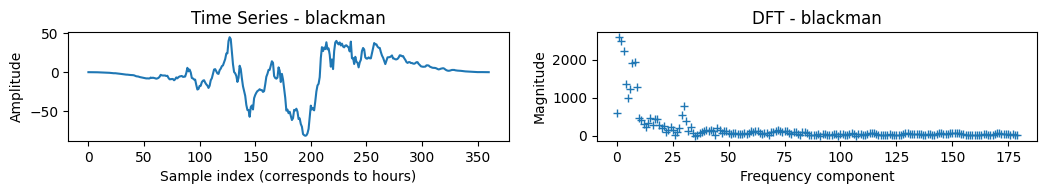

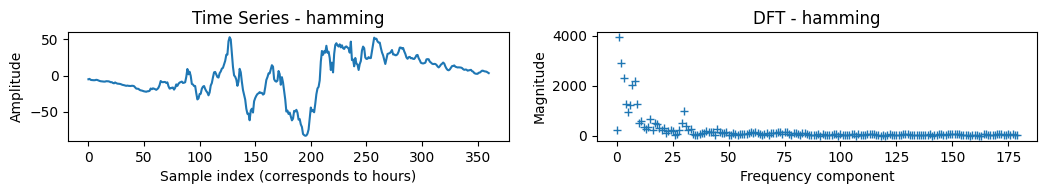

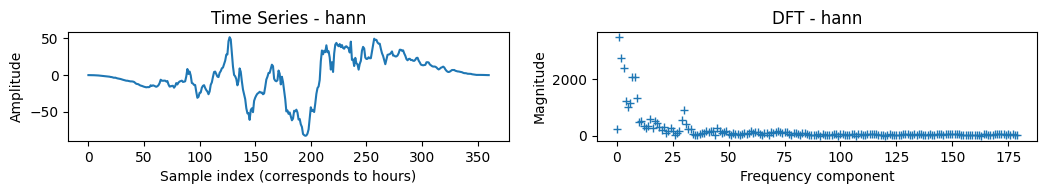

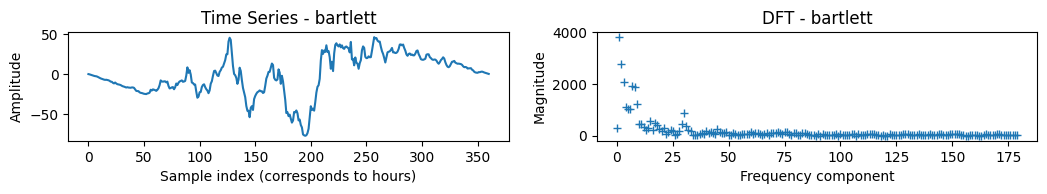

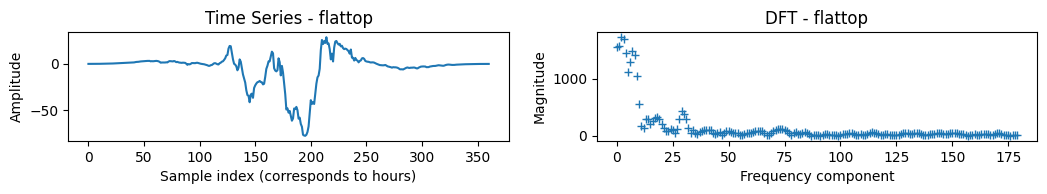

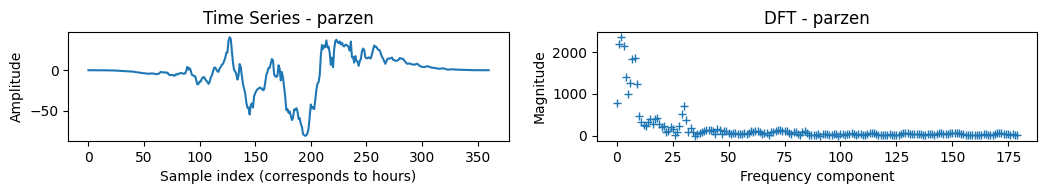

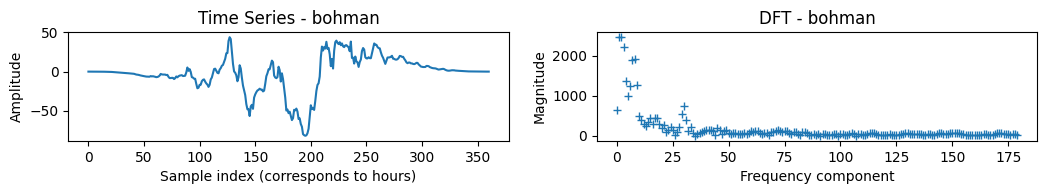

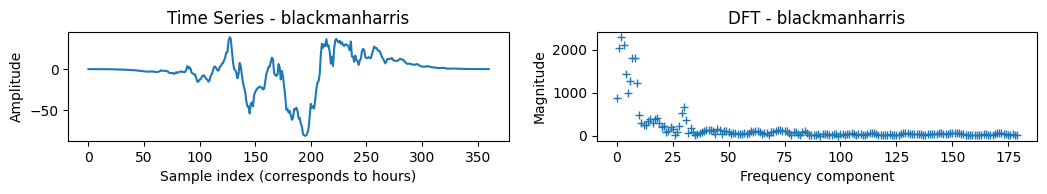

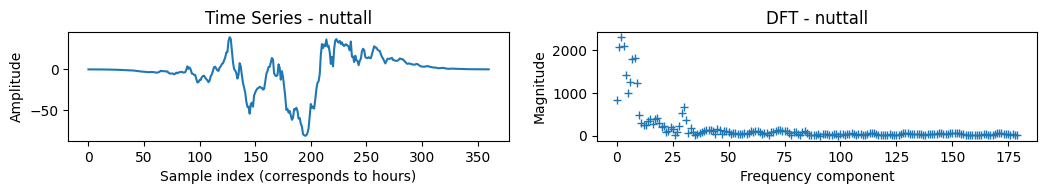

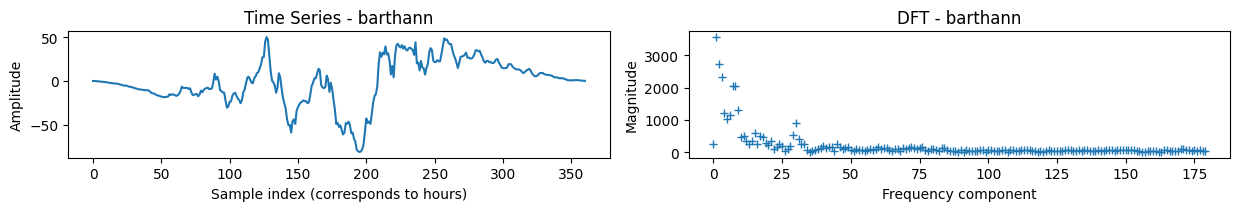

In [4]:
country='Belgium'
start_date = datetime(2022, 1, 1, 0, 0) # year, month, day, hour, min
end_date = start_date + timedelta(hours=24*15)
CI_values=get_CI_values(_dfs, country, start_date, end_date)
CI_values = CI_values - CI_values.mean()                                        # WE REMOVE THE MEAN

# Define the window names
windows = ['boxcar', 'triang', 'blackman', 'hamming', 'hann', 'bartlett', 'flattop', 'parzen', 'bohman', 'blackmanharris', 'nuttall', 'barthann']
# boxar is like no windows at all

# plt.figure(figsize=(6, 30))

pos=1
for window_name in windows:
    window = get_window(window_name, len(CI_values))
    CI_values_2 = CI_values * window   # Apply the window to the time series
    plot_fft(CI_values_2, pos, len(windows), window_name)
    pos+=2

plt.tight_layout()
plt.show()

## Seasonal decomposition

The results are obtained by first estimating the trend by applying a convolution filter to the data. The trend is then removed from the series and the average of this de-trended series for each period is the returned seasonal component. 

See: https://www.statsmodels.org/dev/generated/statsmodels.tsa.seasonal.seasonal_decompose.html

Additive: time series = trend + seasonal + resid

or

Multiplicative: time series = trend * seasonal * resid

where:

- Trend = general tendency to move up or down
- Seasonality = cyclic pattern occurring at regular intervals
- Residual = random noise in the data that isn’t accounted for in the trend or seasonality

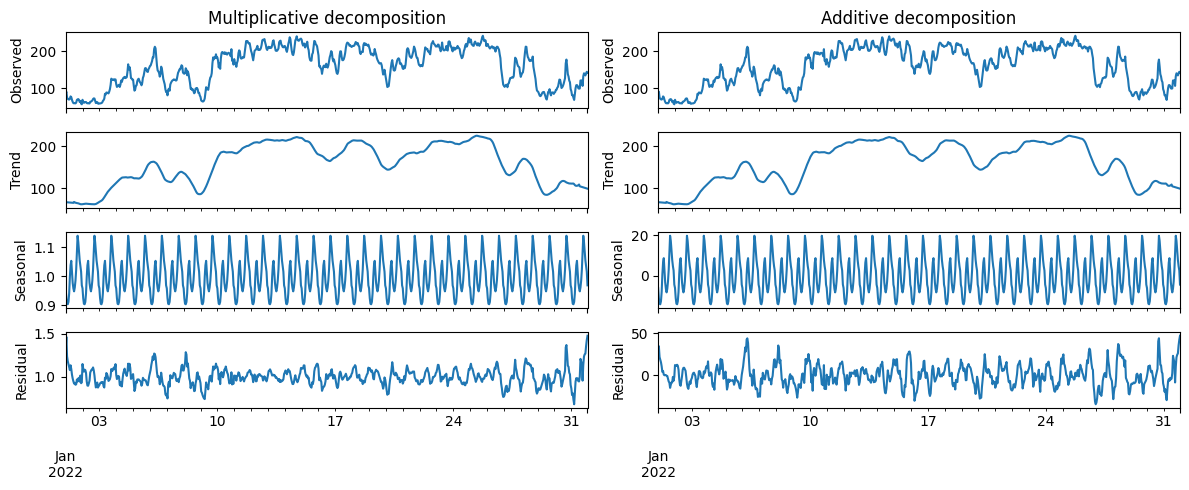

In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

def plotseasonal(res, axes, title):
    res.observed.plot(ax=axes[0], legend=False)
    axes[0].set_ylabel('Observed')
    axes[0].set_title(title)
    res.trend.plot(ax=axes[1], legend=False)
    axes[1].set_ylabel('Trend')
    res.seasonal.plot(ax=axes[2], legend=False)
    axes[2].set_ylabel('Seasonal')
    res.resid.plot(ax=axes[3], legend=False)
    axes[3].set_ylabel('Residual')

start_date = datetime(2022, 1, 1, 0, 0) # year, month, day, hour, min
end_date = start_date + timedelta(hours=24*15)
end_date = datetime(2022, 1, 31, 23, 59) # year, month, day, hour, min

# Import Data
CI_values = get_CI_values(_dfs, country, start_date, end_date)
time_values =  get_datetime_values(_dfs, country, start_date, end_date)
df = pd.DataFrame({'CI':CI_values}, time_values)

# Multiplicative Decomposition 
result_mul = seasonal_decompose(df['CI'], model='multiplicative', extrapolate_trend='freq')
# result_mul = seasonal_decompose(df['values'], model='multiplicative')

# Additive Decomposition
result_add = seasonal_decompose(df['CI'], model='additive', extrapolate_trend='freq')
# result_add = seasonal_decompose(df['values'], model='additive')

# Plot
fig, axes = plt.subplots(ncols=2, nrows=4, sharex=True, figsize=(12,5))

plotseasonal(result_mul, axes[:,0], 'Multiplicative decomposition')
plotseasonal(result_add, axes[:,1], 'Additive decomposition')

plt.tight_layout()
plt.show()